In [25]:
%matplotlib inline

import yaml
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sim_data_file = open("data/sim_training_data/sim_data_annotations.yaml", "r+")
real_data_file = open("data/real_training_data/real_data_annotations.yaml", "r+")

In [3]:
sim_data = yaml.load(sim_data_file)
real_data = yaml.load(real_data_file)

/home/bibagimon/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.
/home/bibagimon/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [5]:
sim_data[1]

{'annotations': [{'class': 'Yellow',
   'x_width': 48.0,
   'xmin': 130.24,
   'y_height': 120.32,
   'ymin': 288.32},
  {'class': 'Yellow',
   'x_width': 47.039999999999964,
   'xmin': 377.6,
   'y_height': 115.51999999999998,
   'ymin': 294.72},
  {'class': 'Yellow',
   'x_width': 48.319999999999936,
   'xmin': 625.6,
   'y_height': 119.04000000000002,
   'ymin': 299.52}],
 'class': 'image',
 'filename': 'sim_data_capture/left0011.jpg'}

In [10]:
def to_df(data):
    items = []

    for entry in data:
        filename = entry['filename']

        for a in entry['annotations']:
            items.append((filename, a['x_width'], a['y_height'], a['class'], a['xmin'], 
                          a['ymin'], a['xmin'] + a['x_width'], a['ymin'] + a['y_height']))

    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(items, columns=column_name)
    
    return df

sim_df = to_df(sim_data)

sim_train, sim_test = train_test_split(sim_df, test_size=0.2)
sim_train.to_csv('train_labels.csv', index=None)
sim_test.to_csv('test_labels.csv', index=None)

In [11]:
!ls

data  Pipeline.ipynb  test_labels.csv  train_labels.csv


In [19]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

sys.path.append("../models/research")

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [27]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
#PATH_TO_CKPT = '/home/bibagimon/tensorflow/workspace/training/trained-inference-graphs/output_inference_graph_v1.pb/frozen_inference_graph.pb'
PATH_TO_CKPT = '/home/bibagimon/tensorflow/workspace/training/pre-trained-model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'annotations', 'label_map.pbtxt')

# Number of classes to detect
NUM_CLASSES = 3

# Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


# Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

from skimage import io
image_np = io.imread('/home/bibagimon/tensorflow/workspace/data/sim_training_data/sim_data_capture/left0611.jpg')

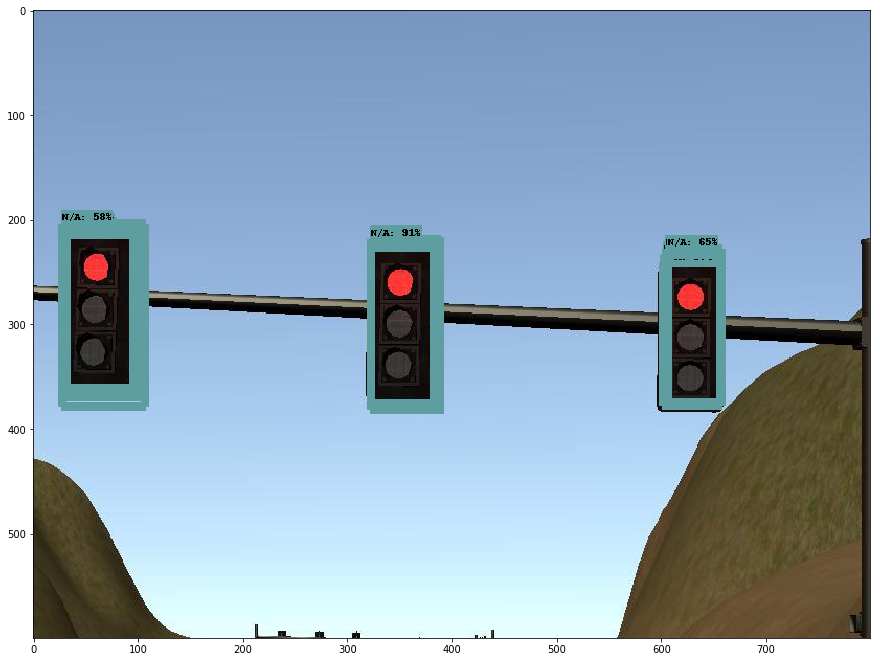

In [33]:
# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Extract image tensor
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Extract detection boxes
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Extract detection scores
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # Extract detection classes
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        # Extract number of detectionsd
        num_detections = detection_graph.get_tensor_by_name(
            'num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=2)
        
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15,15))
        plt.imshow(image_np)
        plt.show()